**Proving NAR is FASTER**

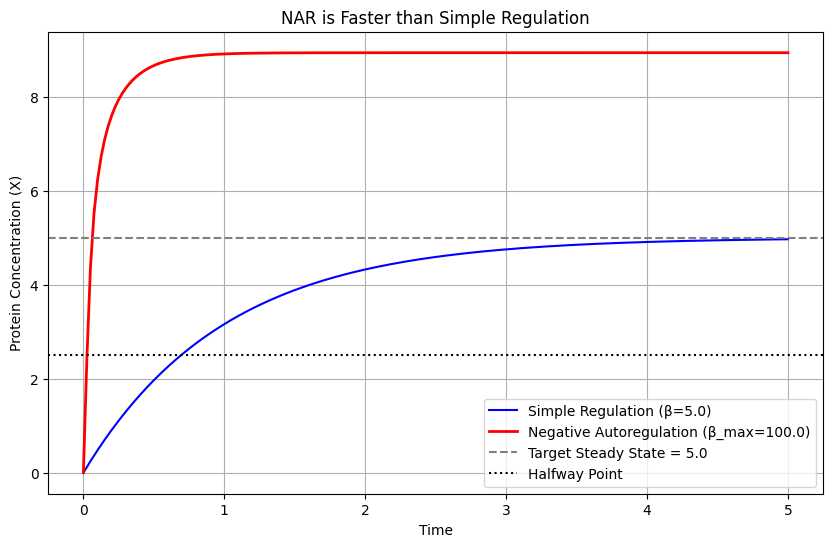

Simple Regulation Response Time (T_1/2) = 0.69 time units
NAR Response Time (T_1/2) = 0.05 time units
--> NAR is 13.8 times faster!


In [1]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# --- Define the Models ---

# This is our reference model: a simple gene circuit
def simple_regulation(X, t, beta, alpha):
    """dY/dt = beta - alpha * Y"""
    return beta - alpha * X

# This is the new model for Negative Autoregulation (NAR)
def nar_regulation(X, t, beta_max, alpha, K, n):
    """
    dX/dt = production - removal
    Production is a decreasing Hill function.
    """
    production = beta_max / (1 + (X/K)**n)
    removal = alpha * X
    return production - removal

# --- Set up a "Mathematically Controlled Comparison" ---
# The goal is for both circuits to reach the same steady state.

# Parameters that are the same for both circuits
alpha = 1.0      # Removal rate (e.g., dilution)
target_X_st = 5.0  # The desired steady-state protein level

# Parameters specific to each circuit design
# 1. For Simple Regulation
beta_simple = target_X_st * alpha  # Calculate the beta needed to reach the target

# 2. For Negative Autoregulation (NAR)
K_nar = target_X_st  # The steady-state is set by the threshold K
beta_max_nar = 20 * beta_simple  # NAR uses a much stronger promoter to be fast
n_nar = 4  # A reasonably "switch-like" repression (cooperativity)

# --- Simulation setup ---
X0 = 0  # Start with no protein
t = np.linspace(0, 5, 200) # Time points for the simulation

# --- Run the simulations ---
solution_simple = odeint(simple_regulation, X0, t, args=(beta_simple, alpha))
solution_nar = odeint(nar_regulation, X0, t, args=(beta_max_nar, alpha, K_nar, n_nar))

# --- Plot the results to VISUALLY compare speed ---
plt.figure(figsize=(10, 6))
plt.plot(t, solution_simple, 'b-', label=f'Simple Regulation (β={beta_simple:.1f})')
plt.plot(t, solution_nar, 'r-', linewidth=2, label=f'Negative Autoregulation (β_max={beta_max_nar:.1f})')

# Add annotations to the plot
plt.axhline(y=target_X_st, color='gray', linestyle='--', label=f'Target Steady State = {target_X_st}')
plt.axhline(y=target_X_st / 2, color='k', linestyle=':', label='Halfway Point')
plt.title('NAR is Faster than Simple Regulation')
plt.xlabel('Time')
plt.ylabel('Protein Concentration (X)')
plt.legend()
plt.grid(True)
plt.show()

# --- NUMERICALLY calculate and compare response times ---
# For simple regulation, the theory is exact
t_half_simple_theory = np.log(2) / alpha

# For NAR, we find the time when the simulation crosses the halfway point
try:
    # Find the first index where the solution is >= halfway point
    half_max_nar_idx = np.where(solution_nar >= target_X_st / 2)[0][0]
    t_half_nar_sim = t[half_max_nar_idx]
    print(f"Simple Regulation Response Time (T_1/2) = {t_half_simple_theory:.2f} time units")
    print(f"NAR Response Time (T_1/2) = {t_half_nar_sim:.2f} time units")
    print(f"--> NAR is {t_half_simple_theory/t_half_nar_sim:.1f} times faster!")
except IndexError:
    print("NAR simulation did not reach halfway point.")

**Proving NAR is more ROBUST**

In [2]:


# --- Demonstrate Robustness ---

# Let's imagine beta fluctuates by 20% up or down
beta_fluctuation = 0.20

# --- For Simple Regulation ---
beta_simple_nominal = target_X_st * alpha
beta_simple_high = beta_simple_nominal * (1 + beta_fluctuation)
beta_simple_low = beta_simple_nominal * (1 - beta_fluctuation)

X_st_simple_nominal = beta_simple_nominal / alpha
X_st_simple_high = beta_simple_high / alpha
X_st_simple_low = beta_simple_low / alpha

print("\n--- Testing Robustness ---")
print("Simple Regulation Steady States:")
print(f"  Nominal beta: X_st = {X_st_simple_nominal:.2f}")
print(f"  High beta:    X_st = {X_st_simple_high:.2f}")
print(f"  Low beta:     X_st = {X_st_simple_low:.2f}")
print(f"==> Output fluctuates by {beta_fluctuation*100}%")


# --- For Negative Autoregulation ---
# For NAR, the steady state is X_st = K / ( (beta_max/(alpha*K))**(1/n) - 1 )**(1/n)
# For large n and beta_max, this is approximately K.
# Let's solve it numerically.
from scipy.optimize import fsolve

def find_nar_steady_state(beta_max, alpha, K, n):
    # We need to find the root of the equation dX/dt = 0
    equation_to_solve = lambda x: nar_regulation(x, 0, beta_max, alpha, K, n)
    # Use fsolve to find the root, starting with a guess of K
    steady_state, = fsolve(equation_to_solve, K)
    return steady_state

beta_nar_nominal = beta_max_nar # From Part 1
beta_nar_high = beta_nar_nominal * (1 + beta_fluctuation)
beta_nar_low = beta_nar_nominal * (1 - beta_fluctuation)

X_st_nar_nominal = find_nar_steady_state(beta_nar_nominal, alpha, K_nar, n_nar)
X_st_nar_high = find_nar_steady_state(beta_nar_high, alpha, K_nar, n_nar)
X_st_nar_low = find_nar_steady_state(beta_nar_low, alpha, K_nar, n_nar)

fluctuation_percent_nar = 100 * (X_st_nar_high - X_st_nar_low) / (2 * X_st_nar_nominal)

print("\nNegative Autoregulation Steady States:")
print(f"  Nominal beta_max: X_st = {X_st_nar_nominal:.2f}")
print(f"  High beta_max:    X_st = {X_st_nar_high:.2f}")
print(f"  Low beta_max:     X_st = {X_st_nar_low:.2f}")
print(f"==> Output fluctuates by only {fluctuation_percent_nar:.1f}%")


--- Testing Robustness ---
Simple Regulation Steady States:
  Nominal beta: X_st = 5.00
  High beta:    X_st = 6.00
  Low beta:     X_st = 4.00
==> Output fluctuates by 20.0%

Negative Autoregulation Steady States:
  Nominal beta_max: X_st = 8.93
  High beta_max:    X_st = 9.29
  Low beta_max:     X_st = 8.51
==> Output fluctuates by only 4.4%
